# Capstone Project - The Battle of Neighborhoods#

## Business Problem##

### Project Description: ###

Most people migrating to various states of Canada require search of a good housing prices as well as good rating schools for their children. The projects aim to create an analysis of features for a neighborhood as a comparative analysis between neighborhoods. The features include median house price and school ratings. This would help people to get awareness of the places before moving to new state, city or place for their work or to start a new life.
The aim of this Project is to help people explore different possibilities and take a better decision on choosing the best neighborhood out of many neighborhoods in Scarborough city based on the distribution of various facilities in and around that neighborhood. 

### The Location: ###

Scarborough 


In [1]:
# Phyton packages
import json # library to handle JSON files
import xml
import pandas as pd #Python library data manipulation and analysis
import requests
from bs4 import BeautifulSoup
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
%matplotlib inline

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# Numpy
import numpy as np

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library
print('Folium installed')
print('Libraries imported.')
import warnings
warnings.filterwarnings("ignore")

Solving environment: done

# All requested packages already installed.

Folium installed
Libraries imported.


In [2]:
# download url data from internet
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
source = requests.get(url).text
Canada_data = BeautifulSoup(source, 'lxml')

In [3]:
# Convert content of PostalCode WIKI table to new dataframe
columns_names = ['Postalcode','Borough','Neighborhood']
toronto = pd.DataFrame(columns = columns_names)
content = Canada_data.find('div', class_='mw-parser-output')
table = content.table.tbody
postcode = 0
borough = 0
neighborhood = 0

for tr in table.find_all('tr'):
    i = 0
    for td in tr.find_all('td'):
        if i == 0:
            postcode = td.text
            i = i + 1
        elif i == 1:
            borough = td.text
            i = i + 1
        elif i == 2: 
            neighborhood = td.text.strip('\n').replace(']','')
    toronto = toronto.append({'Postalcode': postcode,'Borough': borough,'Neighborhood': neighborhood},ignore_index=True)

In [4]:
# clean dataframe 
toronto = toronto[toronto.Borough!='Not assigned']
toronto = toronto[toronto.Borough!= 0]
toronto.reset_index(drop = True, inplace = True)
i = 0
for i in range(0,toronto.shape[0]):
    if toronto.iloc[i][2] == 'Not assigned':
        toronto.iloc[i][2] = toronto.iloc[i][1]
        i = i+1
                                 
df = toronto.groupby(['Postalcode','Borough'], sort=False)['Neighborhood'].apply(', '.join).reset_index()

In [5]:
#Remove all "Not assigned" values
df = df.dropna()
empty = 'Not assigned'
df = df[(df.Postalcode != empty ) & (df.Borough != empty) & (df.Neighborhood != empty)]
df = df[df['Borough'] == 'Scarborough'].reset_index(drop=True)

In [6]:
#Group neighborhood list
def neighborhood_list(grouped):   
    return ', '.join(sorted(grouped['Neighborhood'].tolist()))
                    
grp = df.groupby(['Postalcode', 'Borough'])
df2 = grp.apply(neighborhood_list).reset_index(name='Neighborhood')

In [7]:
#Show the first rows of the DF
df.head(12)

,Postalcode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park"
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge"
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


In [8]:
# Shape of the DF
df.shape

(17, 3)

In [9]:
!wget -q -O 'data.csv'  http://cocl.us/Geospatial_data
df_lon_lat = pd.read_csv('data.csv')
df_lon_lat.columns=['Postalcode','Latitude','Longitude']
df_lon_lat.head()

,Postalcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [10]:
df_new = pd.merge(df,df_lon_lat[['Postalcode','Latitude','Longitude']], on='Postalcode')
df_new.head(12)

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


In [11]:
address = 'Scarborough,Toronto'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude_x = location.latitude
longitude_y = location.longitude
print('The geograpical coordinate of Scarborough,Toronto are {}, {}.'.format(latitude_x, longitude_y))

The geograpical coordinate of Scarborough,Toronto are 43.773077, -79.257774.


In [12]:
# Map location

# create map of Toronto using latitude and longitude values
map_Scarborough = folium.Map(location=[latitude_x, longitude_y], zoom_start=11)

# add markers to map
for latitude, longitude, nei in zip(df_new['Latitude'], df_new['Longitude'], df_new['Neighborhood']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#0000ff',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Scarborough)  
    
map_Scarborough

In [13]:
# The code was removed by Watson Studio for sharing.

In [14]:
# defining radius and limit of venues to get
radius=500
LIMIT=100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_x, 
    longitude_y, 
    radius, 
   LIMIT)
results = requests.get(url).json()

In [15]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['reasons.count', 'reasons.items', 'referralId', 'venue.categories',
       'venue.events.count', 'venue.events.summary', 'venue.id',
       'venue.location.address', 'venue.location.cc', 'venue.location.city',
       'venue.location.country', 'venue.location.crossStreet',
       'venue.location.distance', 'venue.location.formattedAddress',
       'venue.location.labeledLatLngs', 'venue.location.lat',
       'venue.location.lng', 'venue.location.neighborhood',
       'venue.location.postalCode', 'venue.location.state', 'venue.name',
       'venue.photos.count', 'venue.photos.groups', 'venue.venuePage.id'],
      dtype='object')

In [16]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [17]:
# Nearby Venues
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head(5)

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,SEPHORA,"[{'id': '4bf58dd8d48988d10c951735', 'name': 'C...",43.775017,-79.258109
1,Disney Store,"[{'id': '4bf58dd8d48988d1f3941735', 'name': 'T...",43.775537,-79.256833
2,American Eagle Outfitters,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",43.776012,-79.258334
3,Hot Topic,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",43.775450,-79.257929
4,Chipotle Mexican Grill,"[{'id': '4bf58dd8d48988d1c1941735', 'name': 'M...",43.776410,-79.258069


In [18]:
# Categories of Venues

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(5)

,name,categories,lat,lng
0,SEPHORA,Cosmetics Shop,43.775017,-79.258109
1,Disney Store,Toy / Game Store,43.775537,-79.256833
2,American Eagle Outfitters,Clothing Store,43.776012,-79.258334
3,Hot Topic,Clothing Store,43.775450,-79.257929
4,Chipotle Mexican Grill,Mexican Restaurant,43.776410,-79.258069


In [19]:
# TOP 10 Categories
a=pd.Series(nearby_venues.categories)
a.value_counts()[:10]

Clothing Store         7
Coffee Shop            3
Pharmacy               2
Sporting Goods Shop    2
Sandwich Place         2
Cosmetics Shop         2
Tea Room               2
Bakery                 1
Video Game Store       1
Discount Store         1
Name: categories, dtype: int64

In [20]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)      

In [21]:
# Nearby Venues
Scarborough_venues = getNearbyVenues(names=df_new['Neighborhood'],
                                   latitudes=df_new['Latitude'],
                                   longitudes=df_new['Longitude']
                                  )

Rouge, Malvern
Highland Creek, Rouge Hill, Port Union
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park, Ionview, Kennedy Park
Clairlea, Golden Mile, Oakridge
Cliffcrest, Cliffside, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Scarborough Town Centre, Wexford Heights
Maryvale, Wexford
Agincourt
Clarks Corners, Sullivan, Tam O'Shanter
Agincourt North, L'Amoreaux East, Milliken, Steeles East
L'Amoreaux West
Upper Rouge


In [22]:
print('There are {} uniques categories.'.format(len(Scarborough_venues['Venue Category'].unique())))
Scarborough_venues.groupby('Neighborhood').count().head()

There are 59 uniques categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,5,5,5,5,5,5
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",3,3,3,3,3,3
"Birch Cliff, Cliffside West",4,4,4,4,4,4
Cedarbrae,8,8,8,8,8,8
"Clairlea, Golden Mile, Oakridge",10,10,10,10,10,10


In [23]:
# One hot encoding
Scarborough_onehot = pd.get_dummies(Scarborough_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Scarborough_onehot['Neighborhood'] = Scarborough_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Scarborough_onehot.columns[-1]] + list(Scarborough_onehot.columns[:-1])
Scarborough_onehot = Scarborough_onehot[fixed_columns]
Scarborough_grouped = Scarborough_onehot.groupby('Neighborhood').mean().reset_index()
Scarborough_onehot.head(5)

,Neighborhood,American Restaurant,Arts & Crafts Store,Athletics & Sports,Auto Garage,Bakery,Bank,Bar,Breakfast Spot,Bubble Tea Shop,Bus Line,Bus Station,Café,Caribbean Restaurant,Chinese Restaurant,Clothing Store,Coffee Shop,College Stadium,Construction & Landscaping,Convenience Store,Department Store,Discount Store,Electronics Store,Fast Food Restaurant,Fried Chicken Joint,Furniture / Home Store,Gas Station,General Entertainment,Grocery Store,Gym,Hakka Restaurant,Hobby Shop,Indian Restaurant,Intersection,Italian Restaurant,Korean Restaurant,Latin American Restaurant,Lounge,Medical Center,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Motel,Moving Target,Noodle House,Park,Pet Store,Pharmacy,Pizza Place,Playground,Print Shop,Rental Car Location,Sandwich Place,Shopping Mall,Skating Rink,Soccer Field,Spa,Thai Restaurant,Thrift / Vintage Store,Vietnamese Restaurant
0,"Rouge, Malvern",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Rouge, Malvern",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,"Highland Creek, Rouge Hill, Port Union",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"Highland Creek, Rouge Hill, Port Union",0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"Highland Creek, Rouge Hill, Port Union",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [24]:
num_top_venues = 5
for hood in Scarborough_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp =Scarborough_grouped[Scarborough_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                       venue  freq
0  Latin American Restaurant   0.2
1                     Lounge   0.2
2               Skating Rink   0.2
3             Breakfast Spot   0.2
4             Clothing Store   0.2


----Agincourt North, L'Amoreaux East, Milliken, Steeles East----
                 venue  freq
0                 Park  0.33
1           Playground  0.33
2  Arts & Crafts Store  0.33
3      Thai Restaurant  0.00
4        Moving Target  0.00


----Birch Cliff, Cliffside West----
                   venue  freq
0        College Stadium  0.25
1  General Entertainment  0.25
2           Skating Rink  0.25
3                   Café  0.25
4     Mexican Restaurant  0.00


----Cedarbrae----
                venue  freq
0    Hakka Restaurant  0.12
1         Gas Station  0.12
2  Athletics & Sports  0.12
3              Bakery  0.12
4                Bank  0.12


----Clairlea, Golden Mile, Oakridge----
                  venue  freq
0              Bus Line   0.2
1                

In [25]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [26]:
# Common venues near neighborhood
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Scarborough_grouped['Neighborhood']

for ind in np.arange(Scarborough_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Scarborough_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Clothing Store,Breakfast Spot,Skating Rink,Lounge,Latin American Restaurant,College Stadium,Construction & Landscaping,Convenience Store,Department Store,Vietnamese Restaurant
1,"Agincourt North, L'Amoreaux East, Milliken, St...",Arts & Crafts Store,Playground,Park,Vietnamese Restaurant,Clothing Store,Gas Station,Furniture / Home Store,Fried Chicken Joint,Fast Food Restaurant,Electronics Store
2,"Birch Cliff, Cliffside West",General Entertainment,Skating Rink,Café,College Stadium,Vietnamese Restaurant,Clothing Store,Gas Station,Furniture / Home Store,Fried Chicken Joint,Fast Food Restaurant
3,Cedarbrae,Hakka Restaurant,Thai Restaurant,Athletics & Sports,Gas Station,Bakery,Bank,Caribbean Restaurant,Fried Chicken Joint,Discount Store,Convenience Store
4,"Clairlea, Golden Mile, Oakridge",Bus Line,Bakery,Metro Station,Soccer Field,Fast Food Restaurant,Intersection,Park,Bus Station,Vietnamese Restaurant,Construction & Landscaping


In [27]:
# K-Means Clustering
# Using k-means to cluster the neighborhood into 3 clusters.

Scarborough_grouped_clustering = Scarborough_grouped.drop('Neighborhood', 1)
#Scarborough_grouped_clustering = Scarborough_grouped

# run k-means clustering
kmeans = KMeans(n_clusters=3, random_state=0).fit(Scarborough_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0], dtype=int32)

In [28]:
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Clothing Store,Breakfast Spot,Skating Rink,Lounge,Latin American Restaurant,College Stadium,Construction & Landscaping,Convenience Store,Department Store,Vietnamese Restaurant
1,"Agincourt North, L'Amoreaux East, Milliken, St...",Arts & Crafts Store,Playground,Park,Vietnamese Restaurant,Clothing Store,Gas Station,Furniture / Home Store,Fried Chicken Joint,Fast Food Restaurant,Electronics Store
2,"Birch Cliff, Cliffside West",General Entertainment,Skating Rink,Café,College Stadium,Vietnamese Restaurant,Clothing Store,Gas Station,Furniture / Home Store,Fried Chicken Joint,Fast Food Restaurant
3,Cedarbrae,Hakka Restaurant,Thai Restaurant,Athletics & Sports,Gas Station,Bakery,Bank,Caribbean Restaurant,Fried Chicken Joint,Discount Store,Convenience Store
4,"Clairlea, Golden Mile, Oakridge",Bus Line,Bakery,Metro Station,Soccer Field,Fast Food Restaurant,Intersection,Park,Bus Station,Vietnamese Restaurant,Construction & Landscaping


In [29]:
Scarborough_merged =df.iloc[:16,:]

# add clustering labels
Scarborough_merged['Cluster Labels'] = kmeans.labels_

# merge to add latitude/longitude for each neighborhood
Scarborough_merged = Scarborough_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Scarborough_merged.head()


,Postalcode,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",0,Fast Food Restaurant,Print Shop,Vietnamese Restaurant,Clothing Store,General Entertainment,Gas Station,Furniture / Home Store,Fried Chicken Joint,Electronics Store,Discount Store
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",0,Moving Target,Bar,Construction & Landscaping,Vietnamese Restaurant,General Entertainment,Gas Station,Furniture / Home Store,Fried Chicken Joint,Fast Food Restaurant,Electronics Store
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",0,Electronics Store,Mexican Restaurant,Spa,Medical Center,Intersection,Rental Car Location,Breakfast Spot,Pizza Place,Convenience Store,Coffee Shop
3,M1G,Scarborough,Woburn,0,Coffee Shop,Korean Restaurant,Pharmacy,Vietnamese Restaurant,Clothing Store,Gas Station,Furniture / Home Store,Fried Chicken Joint,Fast Food Restaurant,Electronics Store
4,M1H,Scarborough,Cedarbrae,0,Hakka Restaurant,Thai Restaurant,Athletics & Sports,Gas Station,Bakery,Bank,Caribbean Restaurant,Fried Chicken Joint,Discount Store,Convenience Store


In [32]:
Scarborough_merged = pd.merge(Scarborough_merged,df_lon_lat[['Postalcode','Latitude','Longitude']], on='Postalcode')
Scarborough_merged.head()

,Postalcode,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",0,Fast Food Restaurant,Print Shop,Vietnamese Restaurant,Clothing Store,General Entertainment,Gas Station,Furniture / Home Store,Fried Chicken Joint,Electronics Store,Discount Store,43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",0,Moving Target,Bar,Construction & Landscaping,Vietnamese Restaurant,General Entertainment,Gas Station,Furniture / Home Store,Fried Chicken Joint,Fast Food Restaurant,Electronics Store,43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",0,Electronics Store,Mexican Restaurant,Spa,Medical Center,Intersection,Rental Car Location,Breakfast Spot,Pizza Place,Convenience Store,Coffee Shop,43.763573,-79.188711
3,M1G,Scarborough,Woburn,0,Coffee Shop,Korean Restaurant,Pharmacy,Vietnamese Restaurant,Clothing Store,Gas Station,Furniture / Home Store,Fried Chicken Joint,Fast Food Restaurant,Electronics Store,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,0,Hakka Restaurant,Thai Restaurant,Athletics & Sports,Gas Station,Bakery,Bank,Caribbean Restaurant,Fried Chicken Joint,Discount Store,Convenience Store,43.773136,-79.239476


In [33]:
# Map of Clusters
map_clusters = folium.Map(location=[latitude_x, longitude_y], zoom_start=11)


# add markers to the map
markers_colors = []
for latitude, longitude, nei , cluster in zip(Scarborough_merged['Latitude'], 
                                   Scarborough_merged['Longitude'], 
                                   Scarborough_merged['Neighborhood'], 
                                   Scarborough_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fifill_color='#3186cc',
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [34]:
df1=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 0,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df2=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 1,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df3=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 2,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]

In [35]:
# Average house prices
Scarborough_Avg_HousingPrice=pd.DataFrame({"Neighborhood":df["Neighborhood"],
                                      "Average_Housing_Price":[331000.0,285600.0,178000.0,227900.0,217400.0,
                                                               570900.0,225000.0,370500.0,370500.0,430500.0,276200.0,
                                                               279700.0,224300.0,370500.,256400.0,431500.0,430500.0]})

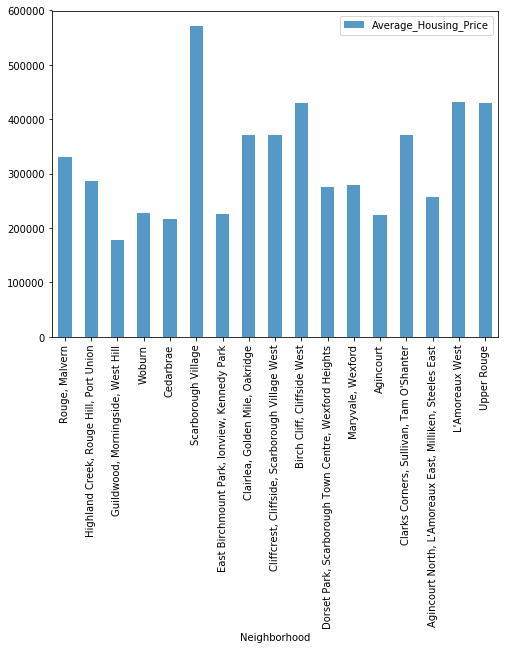

In [36]:
Scarborough_Avg_HousingPrice.set_index('Neighborhood',inplace=True,drop=True)
Scarborough_Avg_HousingPrice.plot(kind='bar',figsize=(8,6),alpha=0.75)

In [37]:
# Scool ratings
clusters=pd.DataFrame({"Cluster1":df1["Neighborhood"],
                      "Cluster2":df2["Neighborhood"],
                      "Cluster4":df3["Neighborhood"]})
clusters = clusters.replace(np.nan, '', regex=True)

In [38]:
new_Scarborough=Scarborough_merged.set_index("Neighborhood",drop=True)
#Source:https://www.greatschools.org
Scarborough_school_ratings=pd.DataFrame({"Neighborhood":df["Neighborhood"],
                                      "Top School Rating":[7,9,5,8,10,10,7,10,1,2,1,2,7,2,3,2,6,]})

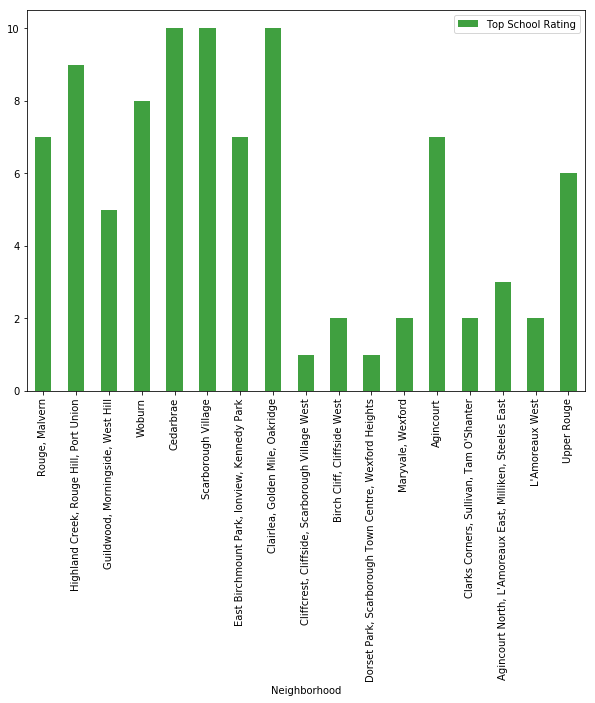

In [39]:
Scarborough_school_ratings.set_index('Neighborhood',inplace=True,drop=True)

Scarborough_school_ratings.plot(kind='bar',figsize=(10,7),color='green',alpha=0.75);

### Conclusion: ###

In this project, through a k-means cluster algorithm we separate the neighborhood into 03 clusters, 
which have similar neighborhoods around them. Using the charts above decision loving to a particular neighborhood 
based on average house prices and school rating can be made